In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/home/raroog/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class TrialSolution(tf.keras.models.Model):
  def __init__(self, conditions, n_i, n_h, n_o=1, activation='sigmoid', equation_type='ODE'):
    super(TrialSolution, self).__init__()
    self.n_i = n_i
    self.n_h = n_h
    self.n_o = n_o
    self.conditions = conditions
    self.hidden_layer = tf.keras.layers.Dense(units=self.n_h, activation=activation)
    self.output_layer = tf.keras.layers.Dense(units=self.n_o, activation='linear')
    
  def call(self, X):
    with tf.GradientTape() as tape:
      X = tf.convert_to_tensor(X)
      response = self.hidden_layer(X)
      response = self.output_layer(response)
      X1 = tf.concat([tf.reshape(X[:,0], shape=(X.shape[0], 1)),
                      tf.constant(1.0, dtype='float64', shape=(X.shape[0], 1))], axis=1)
#       print(X1)
      tape.watch(X1)
      response1 = self.hidden_layer(X1)
#       print(response1)
      response1 = self.output_layer(response1)
    der_resp1 = tape.gradient(response1, X1)
    print(der_resp1)
    der_resp1 = tf.reshape(der_resp1[:,1], shape=(response.shape[0],1))
#     print(der_resp1)
    x = tf.reshape(X[:,0], shape=(response.shape[0],1))
    y = tf.reshape(X[:,1], shape=(response.shape[0],1))
    one = tf.constant(1., dtype='float64', shape=(response.shape[0],1))
    two = tf.constant(2., dtype='float64', shape=(response.shape[0],1))
    pi = tf.constant(np.pi, dtype='float64', shape=(response.shape[0],1))
    response -= response1 + der_resp1
#     print(response)
    response *= x*(one-x)*y
    response += y * two * tf.sin(pi * x)
    
#     print(response)
#     boundary_value = tf.constant(0., dtype='float64', shape=(response.shape[0],1))
    
#     for condition in self.conditions:
#       vanishing = tf.constant(1., dtype='float64', shape=(response.shape[0],1))
#       temp_bc = 0
#       if condition['type'] == 'dirichlet':
#         temp_bc = tf.reshape(condition['function'](X), shape=(response.shape[0],1))           
#         for vanisher in self.conditions:
#           if vanisher['variable'] != condition['variable'] and vanisher['value'] != condition['value']:
#             if vanisher['type'] == 'dirichlet':
#               vanishing *= (X[:, vanisher['variable']]
#                                         - tf.constant(vanisher['value'], dtype='float64', shape=(response.shape[0],1)))
#             elif vanisher['type'] == 'neumann':
#               vanishing *= (X[:, vanisher['variable']]
#                                         - tf.constant(vanisher['value'], dtype='float64', shape=(response.shape[0],1)))
#         boundary_value += temp_bc * vanishing
#         response *= (tf.constant(condition['value'], dtype='float64', shape=(response.shape[0],1))
#                      - tf.reshape(X[:, condition['variable']], shape=(response.shape[0],1)))
#       elif condition['type'] == 'neumann':
#         temp_bc = (tf.reshape(condition['function'](X), shape=(response.shape[0],1))
#                    * tf.reshape(X[:, condition['variable']], shape=(response.shape[0],1)))
#         boundary_value = temp_bc
#         response *= (tf.constant(condition['value'], dtype='float64', shape=(response.shape[0],1))
#                      - tf.reshape(X[:, condition['variable']], shape=(response.shape[0],1)))  
#     response += boundary_value
    return response

In [3]:
bcs = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':lambda X: X[:,1]**3},
        {'variable':0, 'value':0, 'type':'dirichlet',
        'function':lambda X: (tf.constant(1., dtype='float64', shape=(X.shape[0],1))+ X[:,1]**3)*tf.exp(tf.constant(-1., dtype='float64', shape=(X.shape[0],1)))},
        {'variable':1, 'value':0, 'type':'dirichlet',
        'function':lambda X: X[:,0]*tf.exp(-X[:,0])},
        {'variable':1, 'value':1, 'type':'dirichlet',
        'function':lambda X: (X[:,0]+tf.constant(1., dtype='float64', shape=(X.shape[0],1)))*tf.exp(-X[:,0])}]

In [4]:
n_samples = 10
X_p = np.linspace(0, 1, n_samples)
Y_p = np.linspace(0, 1, n_samples)
X_p, Y_p = np.meshgrid(X_p, Y_p)
X_p = X_p.flatten()
Y_p = Y_p.flatten()
samples = np.array([X_p, Y_p]).T

In [5]:
ts = TrialSolution(conditions=bcs, n_i=2, n_h=10, n_o=1)

In [6]:
def diff_loss(network, inputs):
  with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
      inputs = tf.convert_to_tensor(inputs)
      tape.watch(inputs)
      tape2.watch(inputs)
      response = network(inputs)  
    grads = tape.gradient(response, inputs)
  laplace = tape2.gradient(grads, inputs)
#   print(grads)
#   print(laplace)
  two = tf.constant(2, dtype='float64')
  pi = tf.constant(np.pi, dtype='float64')
  loss = tf.square(laplace[:,0] + laplace[:,1]
                   - tf.sin(pi*inputs[:,0])*(two  - pi**2*inputs[:,1]**2))
  return loss

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
train_loss = tf.keras.metrics.Mean('train')

In [8]:
@tf.function
def train_step(X):
  with tf.GradientTape() as tape:
    loss = diff_loss(ts, X)
  gradients = tape.gradient(loss, ts.trainable_variables)
  optimizer.apply_gradients(zip(gradients, ts.trainable_variables))
  train_loss(loss)

In [9]:
ts(tf.convert_to_tensor(samples))

tf.Tensor(
[[ 0.17290998 -0.04393735]
 [ 0.1702283  -0.04432812]
 [ 0.16736147 -0.04495593]
 [ 0.16433906 -0.04582266]
 [ 0.16119145 -0.0469282 ]
 [ 0.15794919 -0.04827034]
 [ 0.15464241 -0.04984478]
 [ 0.15130026 -0.05164513]
 [ 0.14795036 -0.05366296]
 [ 0.14461836 -0.05588784]
 [ 0.17290998 -0.04393735]
 [ 0.1702283  -0.04432812]
 [ 0.16736147 -0.04495593]
 [ 0.16433906 -0.04582266]
 [ 0.16119145 -0.0469282 ]
 [ 0.15794919 -0.04827034]
 [ 0.15464241 -0.04984478]
 [ 0.15130026 -0.05164513]
 [ 0.14795036 -0.05366296]
 [ 0.14461836 -0.05588784]
 [ 0.17290998 -0.04393735]
 [ 0.1702283  -0.04432812]
 [ 0.16736147 -0.04495593]
 [ 0.16433906 -0.04582266]
 [ 0.16119145 -0.0469282 ]
 [ 0.15794919 -0.04827034]
 [ 0.15464241 -0.04984478]
 [ 0.15130026 -0.05164513]
 [ 0.14795036 -0.05366296]
 [ 0.14461836 -0.05588784]
 [ 0.17290998 -0.04393735]
 [ 0.1702283  -0.04432812]
 [ 0.16736147 -0.04495593]
 [ 0.16433906 -0.04582266]
 [ 0.16119145 -0.0469282 ]
 [ 0.15794919 -0.04827034]
 [ 0.15464241 -0.

<tf.Tensor: id=137, shape=(100, 1), dtype=float64, numpy=
array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [7.69430480e-02],
       [1.44505553e-01],
       [1.94628941e-01],
       [2.21324501e-01],
       [2.21395049e-01],
       [1.94819101e-01],
       [1.44751232e-01],
       [7.71386078e-02],
       [2.72143733e-17],
       [0.00000000e+00],
       [1.53770325e-01],
       [2.88806400e-01],
       [3.88990292e-01],
       [4.42344963e-01],
       [4.42477577e-01],
       [3.89347790e-01],
       [2.89268374e-01],
       [1.54138174e-01],
       [5.44287466e-17],
       [0.00000000e+00],
       [2.30482405e-01],
       [4.32903466e-01],
       [5.83085158e-01],
       [6.63062533e-01],
       [6.63248655e-01],
       [5.83586955e-01],
       [4.3355204

In [10]:
EPOCHS = 100000
for epoch in range(EPOCHS):
  train_step(samples)
  if (epoch+1) % 1000 == 0:
    print(f'Epoch: {epoch+1} Loss: {train_loss.result().numpy()}')

Tensor("trial_solution/MatMul_2:0", shape=(100, 2), dtype=float64)
Tensor("trial_solution/MatMul_2:0", shape=(100, 2), dtype=float64)
Epoch: 1000 Loss: 2.184690237045288
Epoch: 2000 Loss: 1.3229392766952515
Epoch: 3000 Loss: 1.021068811416626
Epoch: 4000 Loss: 0.8629454970359802
Epoch: 5000 Loss: 0.7626671195030212
Epoch: 6000 Loss: 0.6932438015937805
Epoch: 7000 Loss: 0.6406441330909729
Epoch: 8000 Loss: 0.5976340770721436
Epoch: 9000 Loss: 0.5616690516471863
Epoch: 10000 Loss: 0.5296845436096191
Epoch: 11000 Loss: 0.5030527710914612
Epoch: 12000 Loss: 0.48041078448295593
Epoch: 13000 Loss: 0.46119317412376404
Epoch: 14000 Loss: 0.4445383846759796
Epoch: 15000 Loss: 0.430052787065506
Epoch: 16000 Loss: 0.41699230670928955
Epoch: 17000 Loss: 0.4055243134498596
Epoch: 18000 Loss: 0.3956184387207031
Epoch: 19000 Loss: 0.38653719425201416
Epoch: 20000 Loss: 0.37800413370132446
Epoch: 21000 Loss: 0.37055084109306335
Epoch: 22000 Loss: 0.3635508120059967
Epoch: 23000 Loss: 0.357274889945983

tf.Tensor(
[[-53.25339174   1.53269811]
 [-32.38946977   2.00670468]
 [-25.07293904   2.71941553]
 [-22.54106967   3.45751624]
 [-19.81019099   4.12127058]
 [-17.11605423   4.6700364 ]
 [-14.86821712   5.08220137]
 [-13.21396521   5.3519565 ]
 [-12.11388248   5.53034986]
 [-11.45795676   5.73967886]
 [-53.25339174   1.53269811]
 [-32.38946977   2.00670468]
 [-25.07293904   2.71941553]
 [-22.54106967   3.45751624]
 [-19.81019099   4.12127058]
 [-17.11605423   4.6700364 ]
 [-14.86821712   5.08220137]
 [-13.21396521   5.3519565 ]
 [-12.11388248   5.53034986]
 [-11.45795676   5.73967886]
 [-53.25339174   1.53269811]
 [-32.38946977   2.00670468]
 [-25.07293904   2.71941553]
 [-22.54106967   3.45751624]
 [-19.81019099   4.12127058]
 [-17.11605423   4.6700364 ]
 [-14.86821712   5.08220137]
 [-13.21396521   5.3519565 ]
 [-12.11388248   5.53034986]
 [-11.45795676   5.73967886]
 [-53.25339174   1.53269811]
 [-32.38946977   2.00670468]
 [-25.07293904   2.71941553]
 [-22.54106967   3.45751624]
 [-

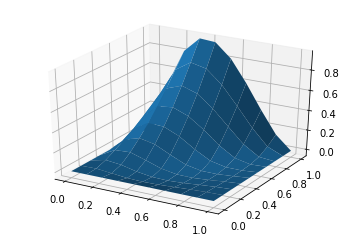

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
new_shape = int(np.sqrt(samples.shape[0]))
Ze5sol = tf.reshape(ts(samples), shape=(samples.shape[0],)).numpy()
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze5sol.reshape((new_shape, new_shape)), label='Numerical - Training')
plt.show()

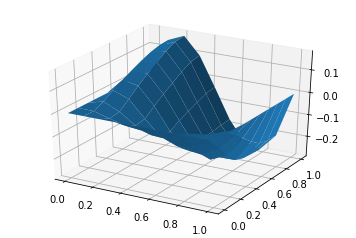

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Ze5anal = np.sin(np.pi*samples[:,0])*samples[:,1]**2
Ze5diff = Ze5sol - Ze5anal
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze5diff.reshape((new_shape, new_shape)), label='Analytic')
# plt.legend()
plt.show()

In [13]:
np.abs(Ze5diff**2).mean()

0.014644337768367256

In [14]:
np.max(np.abs(Ze5diff))

0.2822419086043414

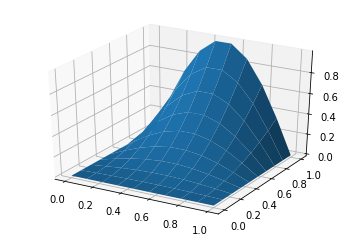

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Ze5anal = np.sin(np.pi*samples[:,0])*samples[:,1]**2
Ze5diff = Ze5sol - Ze5anal
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze5anal.reshape((new_shape, new_shape)), label='Analytic')
# plt.legend()
plt.show()